In [1]:
pip install deap

     |████████████████████████████████| 163kB 21.5MB/s 


In [33]:
#Importamos las librerías y dependencias
import operator
import random
import numpy as np
import math
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
from matplotlib import cm

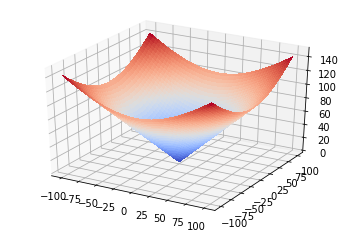

In [34]:
Xg = np.linspace(-100,100,200)
Yg = np.linspace(-100,100,200)
Xg, Yg = np.meshgrid(Xg,Yg)
Zg = np.sqrt(Xg**2 + Yg**2)

fig = plt.figure()
ax = fig.gca(projection = '3d')
surf = ax.plot_surface(Xg,Yg,Zg, cmap=cm.coolwarm,linewidth = 0, antialiased = False )
ax.set_zlim(0,150)
plt.show()

In [35]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, 
    smin=None, smax=None, best=None)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [36]:
#Se define la función objetivo
def funcion_objetivo(x):
    """
    Función objetivo de nuestro problema
    """
    for i in range(len(x)):
        if x[i] > 100 or x[i] < -100:
            return -1,
    res = -(math.sqrt(x[0]**2 + x[1]**2))        
    return res,

In [37]:
def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.uniform(pmin, pmax) for _ in range(size)) 
    part.speed = [random.uniform(smin, smax) for _ in range(size)]
    part.smin = smin
    part.smax = smax
    return part

In [38]:
def updateParticle(part, best, phi1, phi2):
    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
    part[:] = list(map(operator.add, part, part.speed))

In [39]:
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=2, pmin=-100, pmax=100, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi1=2.0, phi2=2.0)
#toolbox.register("evaluate", benchmarks.h1)
toolbox.register("evaluate", funcion_objetivo)

In [40]:
#Función para graficar el proceso de la evolución
def plot_evolucion(log):
    """
    Representa la evolución del mejor individuo en cada generación
    """
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")
    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    ax1.fill_between(gen, fit_mins, fit_maxs, 
                     where=fit_maxs >= fit_mins, facecolor='g', alpha = 0.2)
    ax1.set_xlabel("Generacion")
    ax1.set_ylabel("Fitness")
    ax1.set_ylim([-100, 10])
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)
    plt.savefig("Convergencia.eps", dpi = 300)

In [41]:
#def main():
pop = toolbox.population(n=5)
hof = tools.HallOfFame(1) 
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook()
logbook.header = ["gen", "evals"] + stats.fields
GEN = 50
best = None
for g in range(GEN):
    for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if not best or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
    for part in pop:
            toolbox.update(part, best)
    # Gather all the fitnesses in one list and print the stats
    logbook.record(gen=g, evals=len(pop), **stats.compile(pop))

In [42]:
print(best)
print(best.fitness)

[0.0548089293094165, -0.20380083714723796]
(-0.2110421757705308,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  from ipykernel import kernelapp as app
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


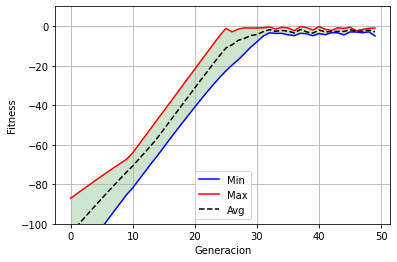

In [43]:
plot_evolucion(logbook)